In [78]:
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
import torch

In [3]:
class SC(torch.nn.Module):
  
  def __init__(self, N, P, T):
    """
    h: p x 1
    L: N x T
    delta: T x 1
    gamma: N x 1
    """
    super(SC, self).__init__()
    
    self.h = torch.rand(P, 1, requires_grad=True, dtype=torch.double)
    self.L = torch.rand(N, T, requires_grad=True, dtype=torch.double)
    self.delta = torch.rand(T, 1, requires_grad=True, dtype=torch.double)
    self.gamma = torch.rand(N, 1, requires_grad=True, dtype=torch.double)
    
    self.N = N
    self.P = P
    self.T = T
    
    self.lambda_L = 0.1
    self.lambda_h = 0.9
        
  def forward(self, X, Y):
    """
    X: N x P
    """
    
    Xh = torch.matmul(X, self.h)  # N x 1
    gamma1 = torch.matmul(self.gamma, torch.ones(1, self.T, dtype=torch.double)) # N x T
    delta1 = torch.matmul(torch.ones(self.N, 1, dtype=torch.double), self.delta.T)
    
    loss = torch.norm(Y - self.L - Xh - gamma1 - delta1, 2) / (self.N * self.T)
    
    loss_penalty = loss + self.lambda_L * torch.norm(self.L, 'nuc') + self.lambda_h * torch.sum(torch.abs(self.h))    

    return loss_penalty

# 1. A toy data

In [40]:
N = 1000
P = 10
T = 100

X = torch.ones(N, P)
Y = torch.ones(N, T)

In [41]:
model = SC(N, P, T)

In [44]:
optimizer = torch.optim.SGD([model.h, model.L, model.delta, model.gamma],
                            lr=0.01, momentum=0.9)

In [50]:
for _ in range(10000):
  optimizer.zero_grad()
  loss = model.forward(X+1, Y)
  loss.backward()
  optimizer.step()

In [52]:
model.L

tensor([[-5.1445e-03,  3.2464e-05,  3.2493e-05,  ...,  3.2471e-05,
          3.2464e-05,  3.2598e-05],
        [ 3.2501e-05, -5.1444e-03,  3.2492e-05,  ...,  3.2579e-05,
          3.2556e-05,  3.2560e-05],
        [ 3.2497e-05,  3.2555e-05, -5.1442e-03,  ...,  3.2544e-05,
          3.2513e-05,  3.2610e-05],
        ...,
        [-1.5553e-06, -1.5721e-06, -1.5653e-06,  ..., -1.5649e-06,
         -1.5641e-06, -1.5676e-06],
        [-1.5553e-06, -1.5721e-06, -1.5653e-06,  ..., -1.5649e-06,
         -1.5641e-06, -1.5676e-06],
        [-1.5553e-06, -1.5721e-06, -1.5653e-06,  ..., -1.5649e-06,
         -1.5641e-06, -1.5676e-06]], requires_grad=True)

# 2. True Data (using categorical variables)

In [277]:
Y = pd.read_csv("../data/synthetic_matrix.csv")
X = pd.read_csv("../data/objects_c.csv")
X = X[['id', 'category_code']]
large = Y.merge(X, left_on='id', right_on='id', how='left')

Y = large.iloc[:, 3:7]
X = large.iloc[:, -1]
X = X.fillna("others")
enc = OneHotEncoder(sparse=False)
X = enc.fit_transform(X.to_numpy().reshape(-1,1))

In [279]:
N, T = Y.shape
_, P = X.shape

In [280]:
X_t = torch.tensor(X).double()
Y_t = torch.tensor(Y.to_numpy()).double()

## 2.1 Run Synthetic Control

In [281]:
model = SC(N, P, T)

In [282]:
optimizer = torch.optim.SGD([model.h, model.L, model.delta, model.gamma],
                            lr=0.1)

In [283]:
# Creat mask
mask = pd.read_csv("../data/mask.csv", index_col=0).to_numpy()
Y_t = torch.multiply(Y_t, torch.tensor(mask, dtype=torch.double))

In [284]:
for _ in range(5000):
  optimizer.zero_grad()
  loss = model.forward(X_t, Y_t)
  loss.backward()
  optimizer.step()

In [285]:
model.L

tensor([[7.8279e-06, 8.4453e-05, 1.7894e-05, 1.3478e-04],
        [6.1287e-05, 6.6939e-05, 4.5202e-05, 9.8462e-05],
        [9.7789e-05, 1.0659e-04, 5.6394e-05, 3.6790e-05],
        ...,
        [1.0546e-04, 3.2982e-05, 7.0968e-05, 2.1370e-05],
        [7.5191e-05, 8.6478e-05, 4.9721e-05, 5.9432e-05],
        [2.7941e-05, 1.1285e-04, 4.2290e-05, 4.9242e-05]], dtype=torch.float64,
       requires_grad=True)

In [286]:
np.savetxt('../data/L1.csv', model.L.detach().numpy())

## Placebo Test

In [213]:
Y = pd.read_csv("../data/synthetic_matrix.csv")
X = pd.read_csv("../data/objects_c.csv")
X = X[['id', 'category_code']]
large = Y.merge(X, left_on='id', right_on='id', how='left')

In [214]:
large = large[large.funding_round_num.isna()] # Select Control group only

In [215]:
Y = large.iloc[:, 3:7]
X = large.iloc[:, -1]
X = X.fillna("others")
enc = OneHotEncoder(sparse=False)
X = enc.fit_transform(X.to_numpy().reshape(-1,1))

N, T = Y.shape
_, P = X.shape

X_t = torch.tensor(X).double()
Y_t = torch.tensor(Y.to_numpy()).double()

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

In [288]:
l2_norms = []
for _ in range(10):
  index = np.random.randint(1, N, size=100)

  synthetic_x = []
  for i in index:
    model = SC(N, P, T)
    optimizer = torch.optim.SGD([model.h, model.L, model.delta, model.gamma],
                              lr=0.01)
    mask = torch.ones(N, T)
    mask[i, :] = 0

    Y_t_local = torch.multiply(Y_t, mask)

    for _ in range(3000):
      optimizer.zero_grad()
      loss = model.forward(X_t, Y_t_local)
      loss.backward()
      optimizer.step()

    print(model.L[i, :])
    synthetic_x.append(model.L[i, :].detach().numpy())
    
  err = (Y.iloc[index] - np.array(synthetic_x)).to_numpy()
  l2_norms.append(np.linalg.norm(err))

tensor([0.2000, 0.5582, 0.8230, 0.7878], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3747, 0.6204, 0.3241, 0.3811], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5146, 0.6359, 0.1511, 0.1947], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5494, 0.7543, 0.2384, 0.2103], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0484, 0.1279, 0.0487, 0.1831], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2919, 0.4936, 0.2587, 0.7468], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2171, 0.4892, 0.6178, 0.7024], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3824, 0.8358, 0.3283, 0.6140], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5848, 0.5371, 0.1358, 0.1820], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3463, 0.4914, 0.7765, 0.1131], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7216, 0.8659, 0.4764, 0.8152], dtype=tor

tensor([0.6393, 0.5339, 0.8658, 0.4739], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2353, 0.1814, 0.6460, 0.6653], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6902, 0.7655, 0.8235, 0.6536], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6474, 0.5222, 0.4136, 0.7393], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5582, 0.5031, 0.1902, 0.6033], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1868, 0.8205, 0.8214, 0.7770], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5596, 0.1234, 0.8259, 0.3839], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1165, 0.1327, 0.4440, 0.4364], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3461, 0.6871, 0.3004, 0.2449], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1397, 0.8011, 0.1720, 0.7234], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4214, 0.5402, 0.8592, 0.6310], dtype=tor

tensor([0.5530, 0.7232, 0.1577, 0.2351], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7584, 0.5482, 0.8449, 0.3975], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3645, 0.5442, 0.7086, 0.1823], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8251, 0.3504, 0.7748, 0.2686], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5657, 0.8360, 0.4650, 0.1408], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3653, 0.3743, 0.0907, 0.4967], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1991, 0.5080, 0.6884, 0.7882], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3374, 0.3848, 0.2091, 0.5899], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2574, 0.7310, 0.2837, 0.4446], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6720, 0.4129, 0.5391, 0.7590], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2105, 0.6130, 0.6505, 0.5792], dtype=tor

tensor([0.8706, 0.7640, 0.4487, 0.7495], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5613, 0.2887, 0.1114, 0.8120], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1017, 0.7935, 0.1538, 0.5506], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7289, 0.5633, 0.2811, 0.6518], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1352, 0.5477, 0.0872, 0.5920], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4370, 0.2240, 0.5380, 0.2756], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7515, 0.3558, 0.8272, 0.6884], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3409, 0.4143, 0.3125, 0.1652], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6887, 0.3890, 0.6900, 0.8399], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3490, 0.5968, 0.1693, 0.7298], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2846, 0.6569, 0.5460, 0.3247], dtype=tor

tensor([0.3955, 0.4198, 0.3656, 0.1802], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4924, 0.0608, 0.0889, 0.3463], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5142, 0.4436, 0.5647, 0.6521], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1734, 0.6310, 0.6798, 0.7045], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1102, 0.5795, 0.1003, 0.7021], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1663, 0.7282, 0.7963, 0.6206], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8369, 0.7809, 0.7810, 0.7910], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4738, 0.3667, 0.1807, 0.2727], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5973, 0.3406, 0.6731, 0.6081], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1323, 0.2958, 0.8123, 0.4421], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1525, 0.5120, 0.4749, 0.1644], dtype=tor

tensor([0.7569, 0.1625, 0.8114, 0.2467], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1918, 0.4235, 0.4975, 0.3498], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8548, 0.5308, 0.4234, 0.7771], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7936, 0.8531, 0.2847, 0.7051], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6153, 0.4194, 0.5781, 0.1697], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6406, 0.7516, 0.1686, 0.7813], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3554, 0.2469, 0.0987, 0.3726], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6491, 0.4372, 0.4871, 0.5791], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7296, 0.8377, 0.6316, 0.4209], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7940, 0.7574, 0.8309, 0.2105], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3774, 0.7386, 0.1142, 0.3606], dtype=tor

tensor([0.1503, 0.8185, 0.6496, 0.2701], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2364, 0.6164, 0.7725, 0.3972], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2813, 0.4924, 0.6660, 0.1059], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1071, 0.1458, 0.0539, 0.0746], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3656, 0.1684, 0.0791, 0.3234], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1286, 0.1900, 0.6865, 0.0673], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0636, 0.6112, 0.2062, 0.0925], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5151, 0.3374, 0.2443, 0.0700], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5507, 0.8161, 0.3909, 0.1126], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2281, 0.7676, 0.2146, 0.3487], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8192, 0.8391, 0.3250, 0.4098], dtype=tor

tensor([0.7366, 0.7191, 0.5124, 0.1990], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7411, 0.8248, 0.8183, 0.4800], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4538, 0.2715, 0.7123, 0.3157], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4238, 0.1974, 0.4836, 0.5672], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4791, 0.1272, 0.7967, 0.7632], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3753, 0.5946, 0.5418, 0.5186], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4082, 0.3741, 0.1439, 0.7931], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2419, 0.6171, 0.1425, 0.1902], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2486, 0.6554, 0.3898, 0.6586], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4712, 0.1230, 0.3537, 0.7513], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1532, 0.2390, 0.4110, 0.4315], dtype=tor

tensor([0.1060, 0.4043, 0.2112, 0.4399], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1908, 0.1487, 0.2063, 0.6495], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1124, 0.4153, 0.6775, 0.3706], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1989, 0.8056, 0.4038, 0.7192], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4629, 0.7242, 0.6111, 0.2464], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5754, 0.6813, 0.1342, 0.7109], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2947, 0.1559, 0.2548, 0.7148], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4149, 0.3740, 0.3403, 0.6962], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8156, 0.1695, 0.6397, 0.2279], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2821, 0.2306, 0.8092, 0.2702], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3572, 0.5115, 0.1214, 0.7274], dtype=tor

tensor([0.2384, 0.1640, 0.1200, 0.5447], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3272, 0.1466, 0.4931, 0.0552], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5361, 0.5409, 0.1505, 0.6571], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6638, 0.4277, 0.7875, 0.6756], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8257, 0.7268, 0.7755, 0.5273], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5806, 0.1541, 0.7010, 0.8528], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7352, 0.2240, 0.8426, 0.5994], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6062, 0.5027, 0.7295, 0.8731], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7366, 0.2742, 0.7772, 0.6220], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2473, 0.2347, 0.3648, 0.1471], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5438, 0.0971, 0.0534, 0.0398], dtype=tor

tensor([0.5460, 0.8046, 0.6739, 0.4043], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3196, 0.6647, 0.2952, 0.1851], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5481, 0.3206, 0.6610, 0.5021], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4224, 0.3199, 0.1561, 0.4584], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5955, 0.8139, 0.1572, 0.7055], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5435, 0.6605, 0.2421, 0.5312], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2283, 0.5428, 0.3173, 0.5372], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3593, 0.1373, 0.7687, 0.0821], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5271, 0.5673, 0.3040, 0.7087], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2958, 0.8036, 0.5612, 0.1920], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7709, 0.4293, 0.8233, 0.1098], dtype=tor

tensor([0.6679, 0.4543, 0.4789, 0.3574], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2262, 0.8055, 0.3696, 0.3937], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7682, 0.4084, 0.1763, 0.4067], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8107, 0.3484, 0.4510, 0.8408], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5735, 0.7382, 0.5206, 0.6524], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5771, 0.2098, 0.1557, 0.2086], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2121, 0.2658, 0.4597, 0.2488], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7049, 0.2624, 0.8179, 0.7367], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2510, 0.7127, 0.3794, 0.3947], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4336, 0.3092, 0.3694, 0.5854], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2913, 0.5582, 0.5820, 0.2711], dtype=tor

In [295]:
np.sqrt(np.var(l2_norms)/10)

101.23255768478882

In [297]:
X.shape

(1541, 42)

# Model 3

In [44]:
Y = pd.read_csv("../data/synthetic_matrix.csv")
X = pd.read_csv("../data/objects_c.csv")
X = X[['id', 'category_code']]
large = Y.merge(X, left_on='id', right_on='id', how='left')

Y = large.iloc[:, 3:7]
X = large.iloc[:, -1]
X = X.fillna("others")
enc = OneHotEncoder(sparse=False)
X = enc.fit_transform(X.to_numpy().reshape(-1,1))

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

In [45]:
embeddings = []
for i in range(31):
  embeddings.append(pd.read_csv(f"../data/embedding/batch-{i}.csv", header=None, delimiter=" ").to_numpy())

In [46]:
X = np.concatenate([X, np.concatenate(embeddings)], axis=1)

In [52]:
N, T = Y.shape
_, P = X.shape

X_t = torch.tensor(X).double()
Y_t = torch.tensor(Y.to_numpy()).double()

# Creat mask
mask = pd.read_csv("../data/mask.csv", index_col=0).to_numpy()
Y_t = torch.multiply(Y_t, torch.tensor(mask, dtype=torch.double))

In [98]:
model = SC(N, P, T)
optimizer = torch.optim.SGD([model.h, model.L, model.delta, model.gamma],
                            lr=0.1)

l_list = []
for _ in range(300):
  optimizer.zero_grad()
  loss = model.forward(X_t, Y_t)
  l_list.append(loss.detach().numpy())
  loss.backward()
  optimizer.step()

In [99]:
model.L

tensor([[0.2002, 0.2382, 0.5123, 0.6657],
        [0.1767, 0.2479, 0.3629, 0.2777],
        [0.6537, 0.6243, 0.2776, 0.4595],
        ...,
        [0.5959, 0.6207, 0.2266, 0.3389],
        [0.6814, 0.1454, 0.6324, 0.5234],
        [0.6154, 0.7843, 0.3957, 0.4861]], dtype=torch.float64,
       requires_grad=True)

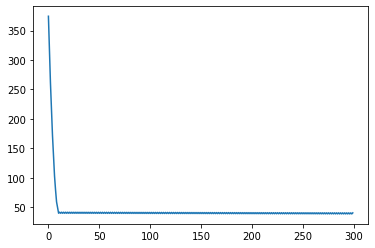

In [100]:
plt.plot(l_list)
# plt.yscale("log")

In [97]:
np.savetxt('../data/L2.csv', model.L.detach().numpy())

In [30]:
# Placebo

l2_norms = []
for _ in range(10):
  index = np.random.randint(1, N, size=100)

  synthetic_x = []
  for i in index:
    model = SC(N, P, T)
    optimizer = torch.optim.SGD([model.h, model.L, model.delta, model.gamma],
                              lr=0.01)
    mask = torch.ones(N, T)
    mask[i, :] = 0

    Y_t_local = torch.multiply(Y_t, mask)

    for _ in range(3000):
      optimizer.zero_grad()
      loss = model.forward(X_t, Y_t_local)
      loss.backward()
      optimizer.step()

    print(model.L[i, :])
    synthetic_x.append(model.L[i, :].detach().numpy())
    
  err = (Y.iloc[index] - np.array(synthetic_x)).to_numpy()
  l2_norms.append(np.linalg.norm(err))

tensor([0.3875, 0.6831, 0.0878, 0.0983], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4377, 0.7045, 0.2124, 0.4968], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0960, 0.0917, 0.1102, 0.5410], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5489, 0.7297, 0.5921, 0.5850], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0647, 0.3067, 0.3453, 0.1112], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5429, 0.7386, 0.6839, 0.8535], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8020, 0.5524, 0.3915, 0.3712], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0753, 0.0645, 0.6756, 0.0541], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8173, 0.6528, 0.1329, 0.8556], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7486, 0.3691, 0.5756, 0.3033], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6421, 0.4587, 0.7689, 0.2909], dtype=tor

tensor([0.5579, 0.1445, 0.4325, 0.2477], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6246, 0.2345, 0.2196, 0.1670], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2727, 0.7582, 0.5883, 0.6933], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4564, 0.6905, 0.4135, 0.2606], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1683, 0.6275, 0.6934, 0.3734], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4474, 0.6972, 0.6728, 0.4840], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7774, 0.2200, 0.7272, 0.7674], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7570, 0.7600, 0.8603, 0.8883], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2460, 0.1696, 0.7628, 0.4402], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8553, 0.3240, 0.7721, 0.8393], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4038, 0.2297, 0.5166, 0.2530], dtype=tor

tensor([0.3557, 0.1750, 0.5226, 0.1717], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3787, 0.5292, 0.4633, 0.1005], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6364, 0.1132, 0.2761, 0.1364], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3952, 0.6581, 0.1095, 0.6404], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5944, 0.3654, 0.5141, 0.1292], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5312, 0.7631, 0.5386, 0.1172], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0942, 0.4611, 0.7650, 0.1865], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0808, 0.1537, 0.4584, 0.2819], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6440, 0.2625, 0.7030, 0.7068], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3455, 0.7208, 0.7039, 0.8332], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2591, 0.5201, 0.6841, 0.5263], dtype=tor

tensor([0.6109, 0.1934, 0.5352, 0.1952], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5035, 0.5270, 0.1349, 0.5011], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1398, 0.6827, 0.7855, 0.1205], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4610, 0.4586, 0.6376, 0.4757], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8495, 0.4595, 0.3132, 0.7374], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4301, 0.1302, 0.4527, 0.5942], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1540, 0.2118, 0.5255, 0.6996], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3018, 0.3589, 0.6152, 0.7836], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3610, 0.1184, 0.1855, 0.0774], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1169, 0.8136, 0.6225, 0.3197], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2963, 0.1583, 0.2578, 0.3697], dtype=tor

tensor([0.6386, 0.7518, 0.1821, 0.1007], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2447, 0.0880, 0.3026, 0.5671], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1831, 0.2068, 0.1915, 0.3052], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2547, 0.7259, 0.3162, 0.2634], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6116, 0.8428, 0.5934, 0.5787], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7082, 0.4081, 0.7081, 0.5220], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8113, 0.3830, 0.2804, 0.7878], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7122, 0.4920, 0.2259, 0.6275], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4001, 0.5794, 0.8370, 0.7324], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1541, 0.2294, 0.7818, 0.8347], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0805, 0.3699, 0.4038, 0.5982], dtype=tor

tensor([0.4184, 0.1216, 0.6758, 0.1676], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2595, 0.3030, 0.1960, 0.6027], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1801, 0.6579, 0.7249, 0.6232], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3425, 0.8057, 0.5650, 0.4437], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2728, 0.5723, 0.2772, 0.1062], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2791, 0.6651, 0.5885, 0.3112], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3630, 0.8443, 0.4940, 0.5093], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7324, 0.3792, 0.7600, 0.1373], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4886, 0.0857, 0.3916, 0.0666], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5040, 0.7073, 0.4715, 0.3788], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7720, 0.1476, 0.2691, 0.3452], dtype=tor

tensor([0.7080, 0.1650, 0.0756, 0.3311], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2689, 0.1500, 0.2667, 0.4056], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8207, 0.7776, 0.4970, 0.7975], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4014, 0.1605, 0.5712, 0.6004], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0699, 0.4572, 0.1435, 0.4558], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5696, 0.1769, 0.6411, 0.3428], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6015, 0.8514, 0.7449, 0.3205], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3178, 0.7089, 0.8172, 0.3145], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4116, 0.7929, 0.3615, 0.2080], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8566, 0.8889, 0.8060, 0.6274], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6111, 0.0954, 0.3092, 0.3636], dtype=tor

tensor([0.6213, 0.4303, 0.3068, 0.3961], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4659, 0.1633, 0.4134, 0.7414], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8068, 0.4216, 0.5693, 0.4274], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1345, 0.5363, 0.6209, 0.5615], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0565, 0.1732, 0.0583, 0.3354], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4827, 0.4038, 0.6137, 0.1378], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7670, 0.6704, 0.8125, 0.1504], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5390, 0.3828, 0.1446, 0.3352], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5040, 0.4313, 0.5446, 0.6809], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3385, 0.1989, 0.6453, 0.4992], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4988, 0.4318, 0.3396, 0.4487], dtype=tor

tensor([0.8029, 0.1113, 0.5494, 0.2932], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0869, 0.1746, 0.6125, 0.4660], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7209, 0.6695, 0.8592, 0.1796], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5223, 0.2711, 0.8201, 0.4763], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0783, 0.4950, 0.4187, 0.4129], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2072, 0.7294, 0.5188, 0.2263], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5835, 0.4741, 0.1916, 0.1007], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1318, 0.1107, 0.2253, 0.3788], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4742, 0.2230, 0.7235, 0.5064], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6255, 0.8024, 0.5798, 0.5951], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7721, 0.6155, 0.3040, 0.4337], dtype=tor

tensor([0.6976, 0.7498, 0.7101, 0.2951], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.0580, 0.5966, 0.0929, 0.0609], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4685, 0.5616, 0.4435, 0.7655], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1921, 0.7733, 0.4629, 0.3980], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6376, 0.4759, 0.8348, 0.6373], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6981, 0.0874, 0.0616, 0.2689], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4206, 0.6885, 0.7112, 0.7583], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2350, 0.2661, 0.3794, 0.2878], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4212, 0.4317, 0.3894, 0.3734], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.8075, 0.5359, 0.4809, 0.8021], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1953, 0.3973, 0.6053, 0.2398], dtype=tor

tensor([0.3961, 0.2456, 0.2579, 0.6601], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3035, 0.7220, 0.6859, 0.0985], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.7128, 0.1040, 0.4871, 0.5689], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1801, 0.3652, 0.3245, 0.2960], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3922, 0.3684, 0.1441, 0.7632], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2713, 0.7090, 0.2959, 0.8392], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6254, 0.6738, 0.5724, 0.5135], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3042, 0.2728, 0.0803, 0.1625], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4483, 0.2228, 0.6980, 0.2112], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2595, 0.8134, 0.4194, 0.2861], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1721, 0.1494, 0.6329, 0.4906], dtype=tor

tensor([0.5319, 0.0833, 0.3121, 0.5995], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.3237, 0.4461, 0.2212, 0.2435], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5271, 0.8638, 0.7059, 0.6086], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1980, 0.4921, 0.5463, 0.5589], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4752, 0.7723, 0.6686, 0.1801], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4237, 0.6805, 0.8202, 0.4722], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6773, 0.5480, 0.0934, 0.5150], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.2662, 0.7219, 0.1679, 0.1602], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.1600, 0.7379, 0.4766, 0.6357], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.6105, 0.2988, 0.4995, 0.5635], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.5128, 0.6480, 0.5765, 0.7021], dtype=tor

In [33]:
l2_norms

[155.2553644196368,
 157.12346017896985,
 176.9487826724381,
 134.21047951931033,
 94.38464615699,
 1845.8810183209728,
 1849.6665621730567,
 188.97714814154372,
 115.76309132686796,
 203.28503841855994]

In [31]:
np.mean(l2_norms)

492.14955913283467

In [32]:
np.sqrt(np.var(l2_norms)/10)

214.56684967632714